<a href="https://colab.research.google.com/github/manoharreddyvoladri/Quantum_Classification/blob/main/CNN__v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aminelaatam/weed-classification")

print("Path to dataset files:", path)

100%|██████████| 378M/378M [00:08<00:00, 46.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aminelaatam/weed-classification/versions/2


Using device: cpu
Classes: ['corn', 'weed']
CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)
Epoch 1/10 - Loss: 1.4179
Epoch 2/10 - Loss: 0.2208
Epoch 3/10 - Loss: 0.1975
Epoch 4/10 - Loss: 0.1548
Epoch 5/10 - Loss: 0.1717
Epoch 6/10 - Loss: 0.1773
Epoch 7/10 - Loss: 0.1302
Epoch 8/10 - Loss: 0.1277
Epoch 9/10 - Loss: 0.1347
Epoch 10/10 - Loss: 0.1275

===== Model Metrics =====
Accuracy: 0.8517
Precision: 0.7990
Recall: 0.7860
F1 Score: 0

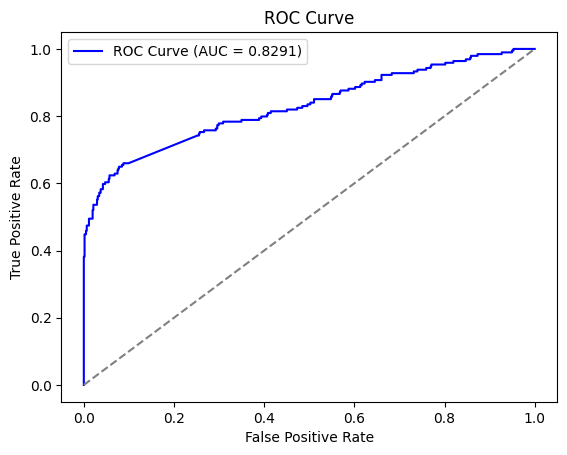

TypeError: Unexpected type <class 'numpy.ndarray'>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, r2_score, silhouette_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import cv2

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ==========================
# 1. Load Dataset (Corn vs. Weed)
# ==========================
DATASET_PATH = "/root/.cache/kagglehub/datasets/aminelaatam/weed-classification/versions/2/CornWeed"

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

train_dataset = ImageFolder(root=os.path.join(DATASET_PATH, 'train'), transform=transform)
test_dataset = ImageFolder(root=os.path.join(DATASET_PATH, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Classes:", train_dataset.classes)

# ==========================
# 2. Define CNN Model
# ==========================
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)
print(model)

# ==========================
# 3. Training Setup
# ==========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==========================
# 4. Train Model
# ==========================
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss / len(train_loader):.4f}")

# ==========================
# 5. Evaluation Metrics
# ==========================
def evaluate_model(model, data_loader):
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs)

    # Compute Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    auc_roc = roc_auc_score(all_labels, all_probs)

    mse = mean_squared_error(all_labels, all_probs)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_labels, all_probs)

    print("\n===== Model Metrics =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    return all_labels, all_probs

labels, probs = evaluate_model(model, test_loader)

# ==========================
# 6. ROC Curve Visualization
# ==========================
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# ==========================
# 7. Bounding Box Detection
# ==========================
def detect_weed(image_path):
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (128, 128))
    image_tensor = transform(image_resized).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        label = "Corn" if predicted.item() == 0 else "Weed"

    # Draw bounding box
    cv2.rectangle(image, (20, 20), (220, 60), (0, 255, 0), 2)
    cv2.putText(image, label, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Detected: {label}")
    plt.show()

# Test bounding box detection on an example image
detect_weed(os.path.join(DATASET_PATH, "test/corn", os.listdir(os.path.join(DATASET_PATH, "test/corn"))[0]))

# ==========================
# 8. Save & Load Model
# ==========================
torch.save(model.state_dict(), "weed_cnn.pth")
print("Model saved as weed_cnn.pth")

loaded_model = CNN().to(device)
loaded_model.load_state_dict(torch.load("weed_cnn.pth"))
loaded_model.eval()
print("Model loaded successfully!")


In [3]:
# 8. Save & Load Model
# ==========================
torch.save(model.state_dict(), "weed_cnn.pth")
print("Model saved as weed_cnn.pth")

loaded_model = CNN().to(device)
loaded_model.load_state_dict(torch.load("weed_cnn.pth"))
loaded_model.eval()
print("Model loaded successfully!")

Model saved as weed_cnn.pth


<ipython-input-3-d4b590a1e6f2>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("weed_cnn.pth"))


Model loaded successfully!


In [4]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define the CNN model (must be the same as the saved model)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
model.load_state_dict(torch.load("/content/weed_cnn.pth", map_location=device))
model.eval()

# Image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def predict_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert to rgb for matplotlib
    h, w, _ = image.shape
    image_tensor = transform(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        label = "Corn" if predicted.item() == 0 else "Weed"
        color = (0, 255, 0) if predicted.item() == 0 else (0, 0, 255)

    cv2.rectangle(image, (0, 0), (w, h), color, 5)
    cv2.putText(image, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()





<ipython-input-4-3027c9fbc256>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/weed_cnn.pth", map_location=device))


In [13]:
def predict_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    h, w, _ = image.shape

    # Convert to PIL Image before applying transforms
    image_pil = Image.fromarray(image_rgb)
    image_tensor = transform(image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        probability = torch.softmax(output, dim=1)
        _, predicted = torch.max(output, 1)
        label = "Corn" if predicted.item() == 0 else "Weed"
        color = (255, 0, 0) if predicted.item() == 0 else (0, 0, 255) # Red for Corn, Blue for Weed
        confidence = probability[0][predicted.item()].item()

    # Draw bounding box and display results
    cv2.rectangle(image, (0, 0), (w, h), color, 5)
    cv2.putText(image, f"{label} ({confidence:.2f})", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.imshow(image_rgb)  # Display the image using matplotlib
    plt.axis('off')
    plt.title(f"Prediction: {label}, Confidence: {confidence:.2f}")
    plt.show()


In [14]:
# Assume image_path is the path to your image
image_path = "/content/WhatsApp Image 2025-02-16 at 11.22.46_82d54615.jpg"
image = cv2.imread(image_path) # Read the image using cv2.imread
# Convert the image to a PIL Image before applying the transform
from PIL import Image
image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
image_tensor = transform(image).unsqueeze(0).to(device)

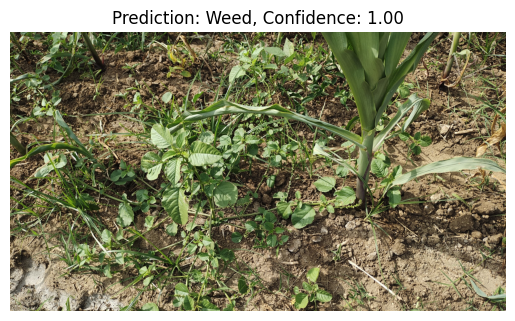

In [15]:
predict_image(image_path)
